In [1]:
from multiprocessing import Pool
from scipy.stats import poisson
from scipy.optimize import curve_fit
from scipy.signal import convolve2d
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
import emcee
import corner
from IPython.display import display, Math
from fonctions import *


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_56178/1479609177.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


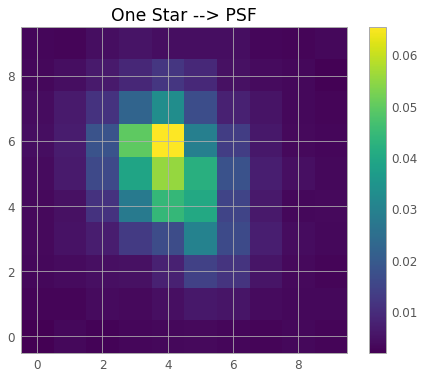

In [33]:
# Opening the images
img = fits.getdata('image2.fit')

# Averaging the calibration frames
bias = averageFolder('bias')
dark = averageFolder('dark')
flat = averageFolder('flat')
#
# Image calibrated using the different calibration frames
image_clean = calibrate(img, bias, dark, flat)

# PSF of one star
#PSF = image_clean[2926-10:2926+10, 2029-10:2029+10]
PSF = image_clean[2628:2638, 822:832]
PSF = PSF / np.sum(PSF)  # normalized as a distribution to 1
plt.figure()
plt.title('One Star --> PSF')
plt.imshow(PSF, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_56178/641524138.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


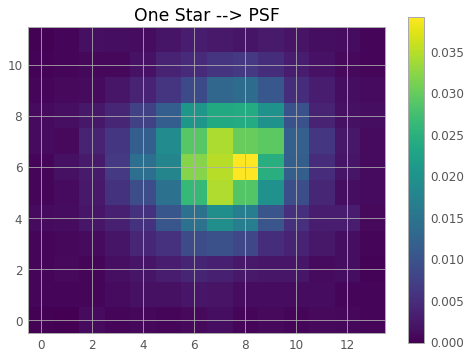

In [32]:

# PSF of one star
#PSF = image_clean[2926-10:2926+10, 2029-10:2029+10]
PSF = image_clean[814:826, 3224:3238]
PSF = PSF / np.sum(PSF)  # normalized as a distribution to 1
plt.figure()
plt.title('One Star --> PSF')
plt.imshow(PSF, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()


mean 4.2439491659138735, median 4.132773590157353, std 4.281351885686402


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_56178/2720888165.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


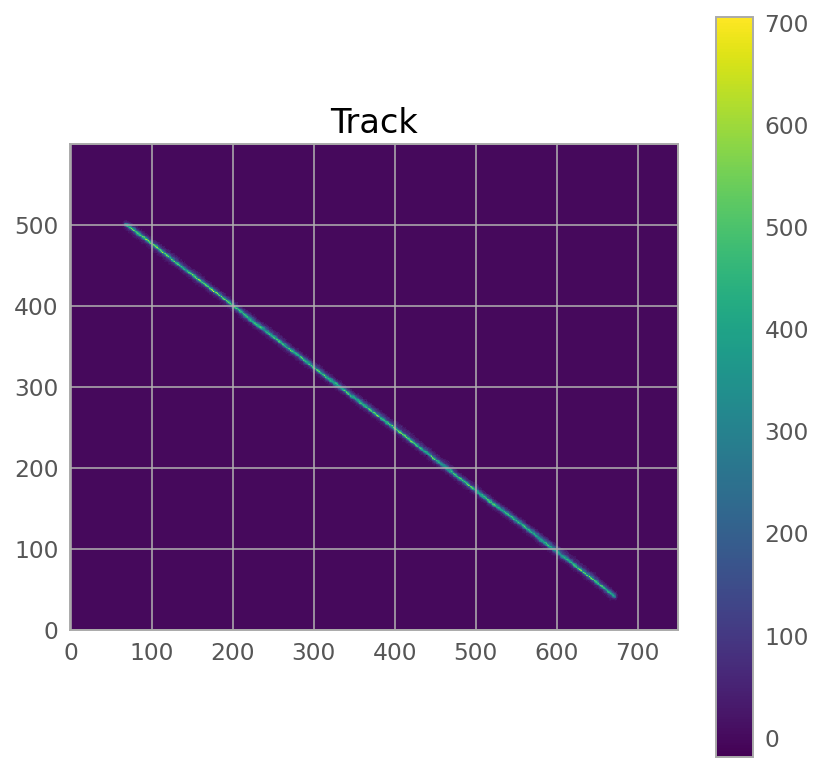

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_56178/2720888165.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


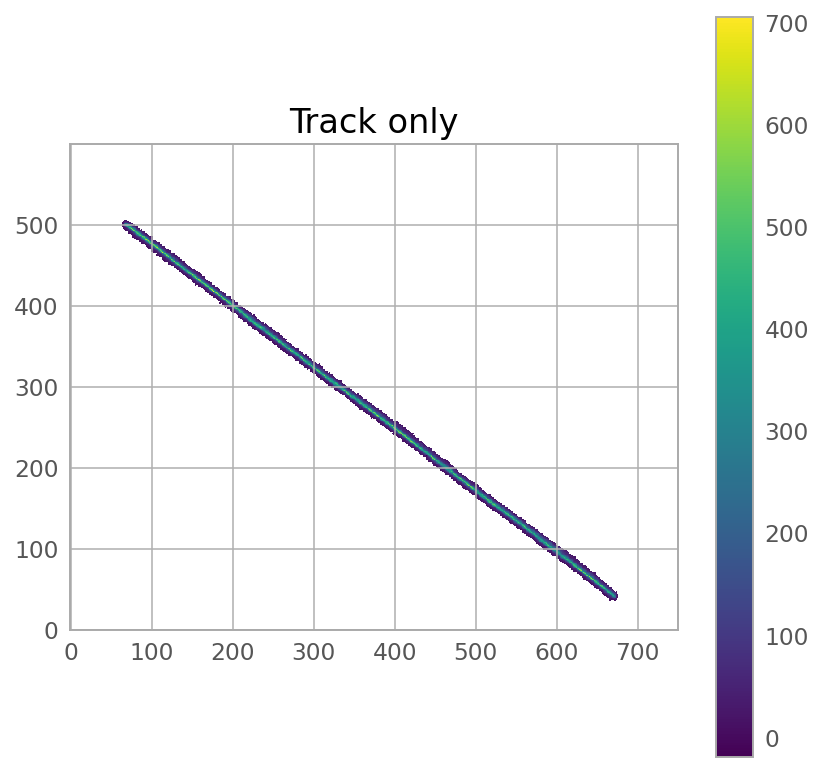

In [31]:
# small outcut of a track
real_data = image_clean[750:1280, 3100:3800]
mask = make_source_mask(real_data, nsigma=5, npixels=1000, dilate_size=2)
track = np.ma.array(real_data, mask=np.logical_not(mask), fill_value=0)
mean, median, std = sigma_clipped_stats(real_data, sigma=4.0, mask=mask)
print('mean {}, median {}, std {}'.format(mean, median, std))

real_data = track.filled()

plt.figure()
plt.title('Track')
plt.imshow(real_data, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Track only')
plt.imshow(track, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_56178/394740788.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(ticks=ticks)


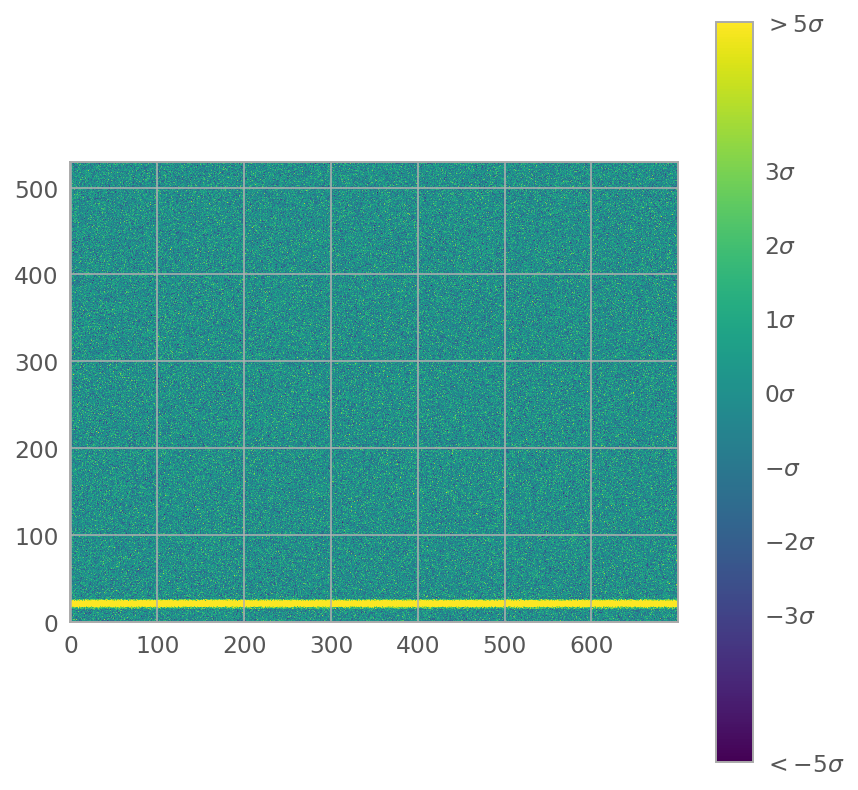

In [15]:
# Create fake data
true_parameters = (20, 20, 3, 500)
track_data = simplerTrackModel(np.shape(real_data), *true_parameters)
track_data = convolve2d(track_data, PSF, 'same') + np.random.normal(loc=mean, scale=std, size=np.shape(real_data))

tick_labels = [r'$<-5\sigma$', r'$-3\sigma$', r'$-2\sigma$', r'$-\sigma$', r'$0\sigma$', r'$1\sigma$', r'$2\sigma$', r'$3\sigma$', r'$>5\sigma$']
ticks = mean + std * np.array([-5, -3, -2, -1, 0, 1, 2, 3, 5])

plt.figure(figsize=(7,7),dpi=140)
#plt.title('fake data')
plt.imshow(track_data, origin='lower', cmap='viridis', interpolation='none', vmin=-5*std+mean, vmax=5*std+mean)
cbar = plt.colorbar(ticks=ticks)
cbar.ax.set_yticklabels(tick_labels)
plt.show()

4.445748445097006
0.0


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_56178/1843189443.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(ticks=ticks)


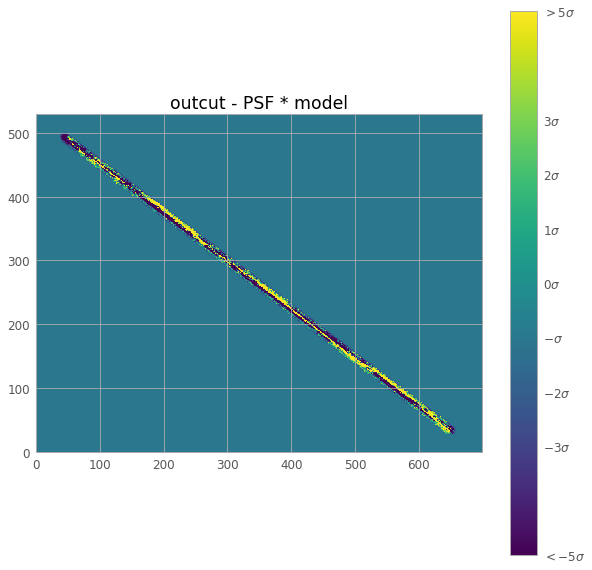

In [16]:
# Convolution of model and PSF to get what we would measure
initial_guess = (494, 43, 33, 650, 6, 1200)
if len(initial_guess) == 4:
    track_model = simplerTrackModel(np.shape(real_data), *initial_guess)
elif len(initial_guess) == 6:
    track_model = trackModel(np.shape(real_data), *initial_guess)
convolved_track = convolve2d(track_model, PSF, 'same')
print(reducedGoodnessModel(real_data, convolved_track + mean, std))
print(pvalue(real_data, convolved_track + mean, std))

plt.figure(figsize=(10,10))
plt.title('outcut - PSF * model')
plt.imshow(real_data-convolved_track, origin='lower', cmap='viridis', interpolation='none', vmin=-5*std+mean, vmax=5*std+mean)
cbar = plt.colorbar(ticks=ticks)
cbar.ax.set_yticklabels(tick_labels)
plt.show()

In [17]:
# Model parameter fitting using Marginalization & uncertainty estimation
# source https://emcee.readthedocs.io/en/stable/tutorials/line/
pos = initial_guess + 1e-1 * np.random.randn(200, len(initial_guess))
nwalkers, ndim = pos.shape
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args=(real_data, std, PSF, mean, False), pool=pool)
    sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [27:51<00:00,  2.99it/s]


/opt/homebrew/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


[nan nan nan nan nan nan]


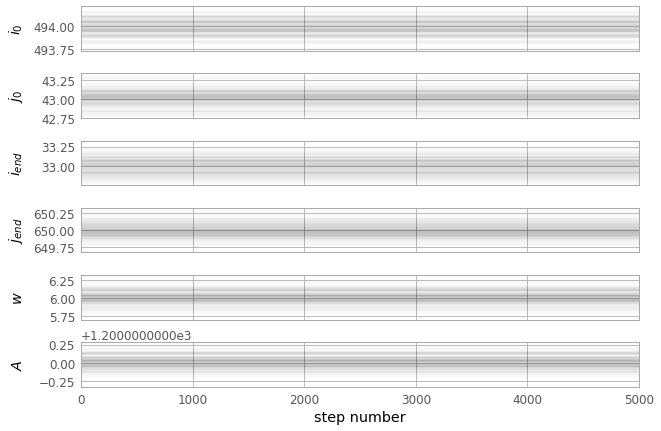

In [8]:
# looking at the steps
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
if ndim == 4:
    labels = [r'$i_0$', r'$i_{end}$', r"w", r"A"]
elif ndim == 6:
    labels = [r'$i_0$', r'$j_0$', r'$i_{end}$', r'$j_{end}$', r"$w$", r"$A$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.01)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# autocorrection time
tau = sampler.get_autocorr_time()
print(tau)


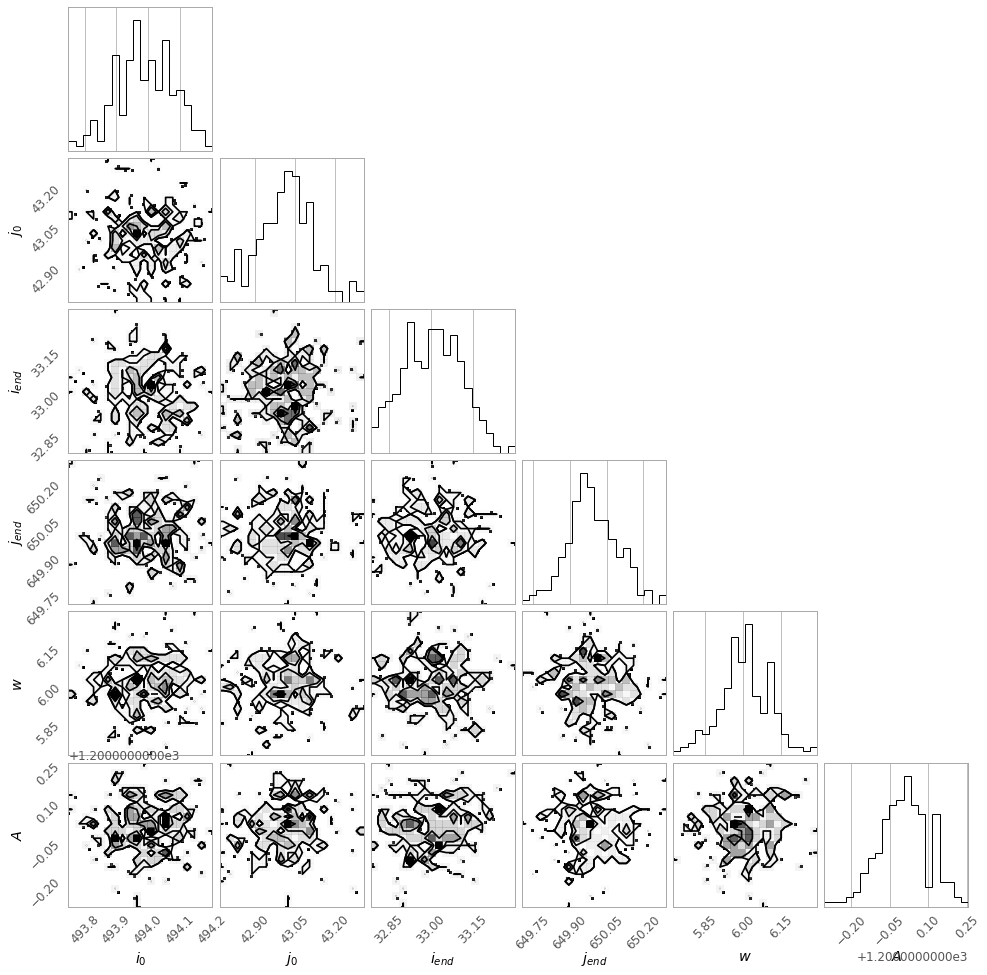

In [9]:
flat_samples = sampler.get_chain(discard=500, thin=10, flat=True)
fig = corner.corner(flat_samples, labels=labels)#, truths=((true_parameters[0], true_parameters[1], true_parameters[2], true_parameters[3])))


In [10]:
# results
from IPython.display import display, Latex
theta = np.zeros(ndim)
theta_max = np.zeros(ndim)
theta_error = np.zeros(ndim)
for i in range(ndim):
    theta[i] = np.mean(flat_samples[:, i])
    n, bins= np.histogram(flat_samples[:, i].flatten(), bins=20)
    theta_max[i] = bins[np.argmax(n)]
    theta_error[i] = np.std(flat_samples[:, i])
    txt = "{2} $= {0:.1f}\pm {1:.1f}\ ({3:.1f})$".format(
        theta[i], theta_error[i], labels[i], theta_max[i])
    display(Latex(txt))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

chi^2:  7.305635230992216
p-value:  0.0


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_56178/2992610513.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ca = plt.colorbar(ticks=ticks)


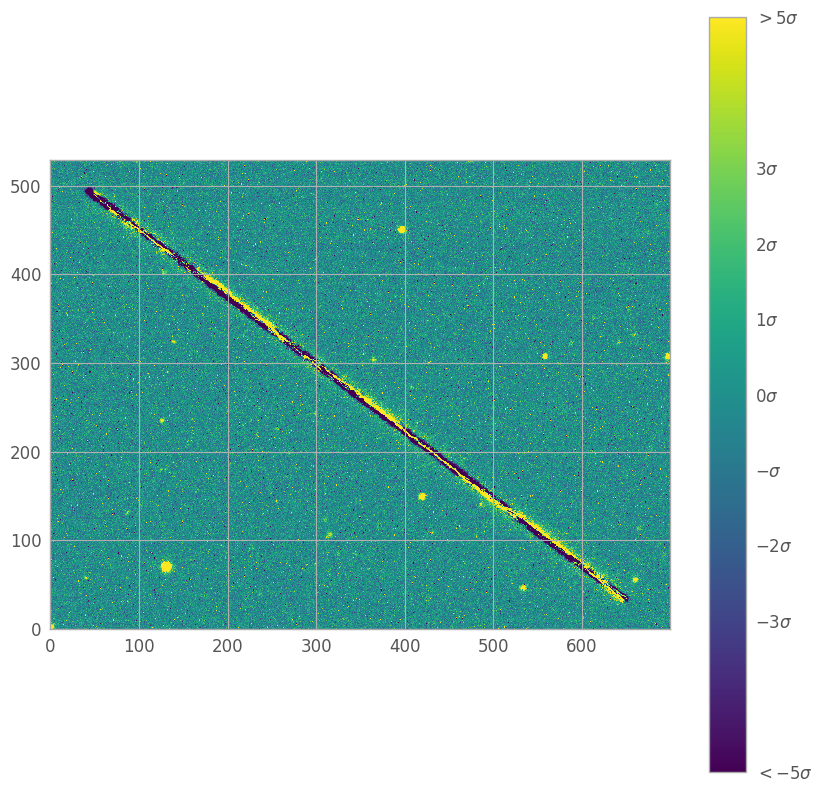

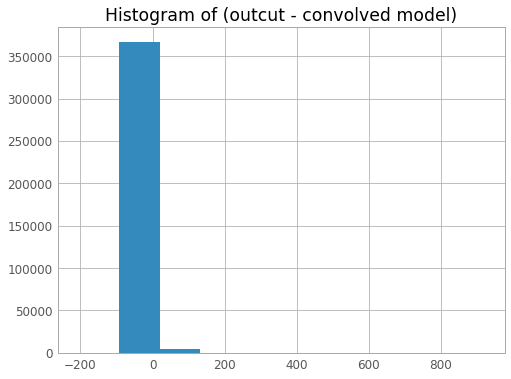

In [11]:
# best model
if ndim == 4:
    best_model = convolve2d(simplerTrackModel(np.shape(real_data), *theta), PSF, 'same')
elif ndim == 6:
    best_model = convolve2d(trackModel(
        np.shape(real_data), *theta), PSF, 'same')
chi2 = reducedGoodnessModel(real_data, best_model, std)
print('chi^2: ', chi2)
print('p-value: ', pvalue(real_data, best_model, std))

plt.figure(figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
#norm = ImageNormalize(stretch=SqrtStretch())
img = real_data - best_model
plt.imshow(img, origin='lower', cmap='viridis', interpolation='none', vmin=-5*std+mean, vmax=5*std+mean)
ca = plt.colorbar(ticks=ticks)
ca.ax.set_yticklabels(tick_labels)
plt.show()

#matplotlib.rcParams['figure.f#igsize'] = [10, 10]
plt.figure()
plt.title('Histogram of (outcut - convolved model)')
plt.hist(img.flatten(), bins=10)
#plt.yscale('log')
plt.show()


No fit, parameters =  [4.195688449205799]


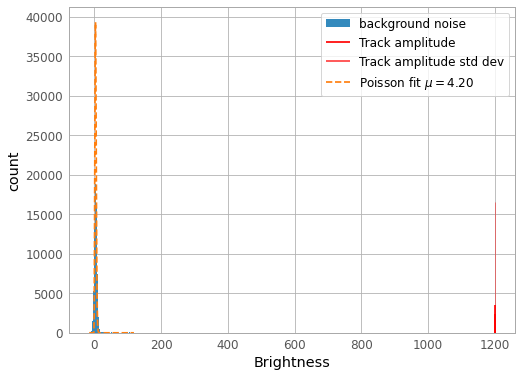

SNR = 286.01


In [12]:
# signal to noise ratio of the track

# Image without the track
masked_image = np.ma.array(track_data, mask=mask, fill_value=0)

# poisson distribution, for fitting
def fitfun(k, lamb):
    return poisson.pmf(k, lamb)

# histogram of background noise compared to amplitude of track
plt.figure()
entries, bin_edges, patches = plt.hist(masked_image.flatten(), bins=256, label='background noise')
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
std_amplitude = np.std(flat_samples[:, -1])
amplitude = theta[-1]
plt.vlines(amplitude, ymin=0, ymax=3500, label='Track amplitude', color='r')
plt.vlines([amplitude-std_amplitude, amplitude+std_amplitude],
           ymin=0, ymax=[0.68*3500, 0.68*3500], label='Track amplitude std dev', color='r', alpha=0.75)
plt.axvspan(amplitude-std_amplitude, amplitude, alpha=0.25, color='red', ymin=0, ymax=0.4)
plt.axvspan(amplitude, amplitude+std_amplitude,
            alpha=0.25, color='red', ymin=0, ymax=0.4)
#plt.plot(bin_middles, np.sum(entries) * poisson.pmf(bin_middles, 1e6), color='tab:orange', label='Poisson fit')
# Poisson fitting
parameters = [mean]
try:
    parameters, cov_matrix = curve_fit(fitfun, bin_middles, entries, parameters)
except Warning:
    print('No fit, parameters = ', parameters)

yfit = fitfun(bin_middles.astype(int), *parameters)
lbl = r'Poisson fit $\mu={:.2f}$'.format(parameters[0])
plt.plot(bin_middles.astype(int), np.sum(entries)/np.sum(yfit) * yfit, '--',
         color='tab:orange', label=lbl)
plt.xlabel(r'Brightness')
plt.ylabel('count')
plt.legend()
plt.show()

SNR = amplitude/parameters[0]
print('SNR = {:.2f}'.format(SNR))

